In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

data = pd.read_csv("train.csv")

In [2]:
# Rauschen entfernen
# Gemacht über eine Korrelationsmatrix und davon dann das obere Dreieck auswählen    
corr_matrix = data.corr().abs()
upper = corr_matrix.where((np.triu(np.ones(corr_matrix.shape), k=1) + np.tril(np.ones(corr_matrix.shape), k=-1)).astype(bool))

#Finde die Features, die eine Korrelation von größer als 0.95 besitzen
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

#Entferne gefundene Features
print("Entfernte Features: ", to_drop)
data.drop(to_drop, axis = 1, inplace=True)

# Da A1, B1, C1, D1, E1 alle von I und A2, B2, C2, D2, E2 abhängen, können wir diese auch gleich entfernen, da I und A1 entfernt wurden.
data.drop(["B1", "C1", "D1", "E1"], axis = 1, inplace=True)

# print(data["Target"].value_counts())

Entfernte Features:  ['A1', 'I']


In [3]:
# Oversampling der Minority Klasse, um so Informationen der Minority Klasse nicht zu verlieren
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Modell fitten und die Daten generieren
oversampled_trainX, oversampled_trainY = sm.fit_sample(data.drop('Target', axis=1), data['Target'])
data = pd.concat([pd.DataFrame(oversampled_trainX), pd.DataFrame(oversampled_trainY)], axis=1)

['C3', 'F', 'G', 'H', 'D2', 'E2', 'A2', 'B2', 'C2']


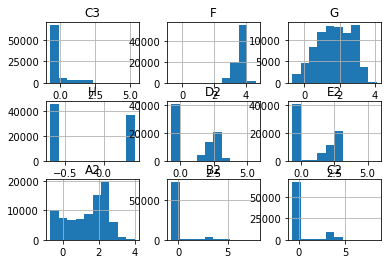

In [4]:
# Ausreißer entfernen geht nicht einfach, da viele Nullen enthalten sind
# Selektives Ausreißer entfernen durch IQR bringt Bias ins Bild, wahrscheinlich nicht ideal

# Entferne alle Outlier mit IQR
# Q1 = data.quantile(q=.25)
# Q3 = data.quantile(q=.75)
# IQR = Q3 - Q1

# data = data[~((data < (Q1-1.5*IQR)) | (data > (Q3+1.5*IQR))).any(axis=1)]

# Transformiere Daten, sodass diese nicht so nach links skewen. Hier durch einen log Transform.
# Da log(0) = undefiniert, addieren wir 0.5 zu allen Features hinzu, um den Log darauf trotzdem verwenden zu können

data_zero = data.drop("Target", axis=1)
feature_names = list(data_zero.columns)
print(feature_names)
data_zero[feature_names] += 0.5

transformed_data = np.log(data_zero[feature_names])
transformed_data.hist()

data = pd.concat([transformed_data, data["Target"]], axis=1)

In [5]:
#Normalisieren (Min-Max Scaling)
data_norm = np.divide(data - data.min(), data.max() - data.min())

In [6]:
feature_names = list(data_norm.columns)
feature_names.remove("Target")
X = data_norm[feature_names]
y = data_norm["Target"]

# 80/20 Split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_pred, y_test))
print("F1 Score: ", f1_score(y_pred, y_test)) 

Accuracy Score:  0.999329268292683
F1 Score:  0.9993268465822166


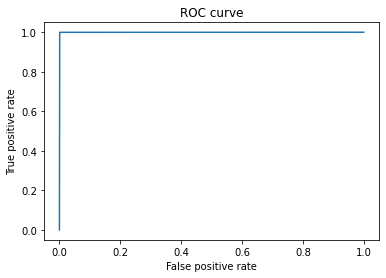

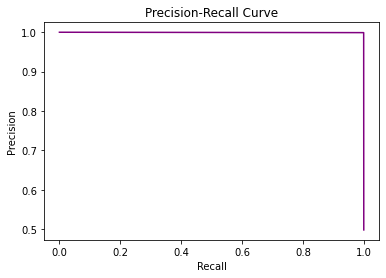

In [7]:
# Ergebnis visualisieren

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

ax.set_title('Precision-Recall Curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')


plt.show()